Saving wines_SPA.csv to wines_SPA.csv


<ipython-input-4-12df22b739e2>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rating_class'] = df['rating'].round().astype(int)


Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7048 - loss: 0.5756 - val_accuracy: 0.8863 - val_loss: 0.2666
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9025 - loss: 0.2561 - val_accuracy: 0.9053 - val_loss: 0.2216
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9351 - loss: 0.1759 - val_accuracy: 0.9263 - val_loss: 0.1971
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9345 - loss: 0.1621 - val_accuracy: 0.9389 - val_loss: 0.1766
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9468 - loss: 0.1422 - val_accuracy: 0.9474 - val_loss: 0.1565
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9508 - loss: 0.1217 - val_accuracy: 0.9495 - val_loss: 0.1494
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9646 - loss: 0.0967 - val_accuracy: 0.9474 - val_loss: 0.1533
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9595 - loss: 0.1054 - val_accuracy: 0.9558 - v

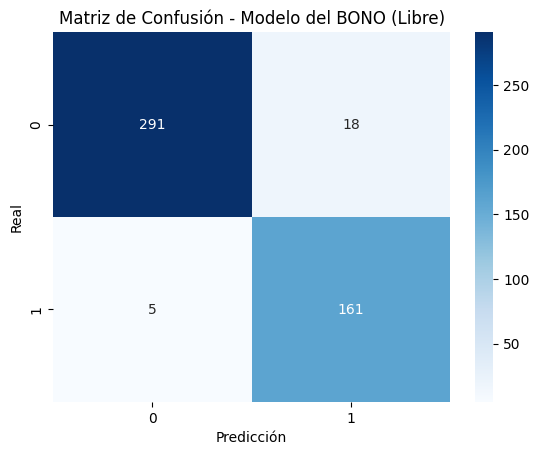

In [4]:
# Modelo del BONO - Arquitectura libre con mayor F1-Score

# 1. Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from google.colab import files
uploaded = files.upload()
import pandas as pd
df = pd.read_csv(next(iter(uploaded)))

# 3. Filtrar clases 4 y 5
df = df[df['rating'].round().isin([4, 5])]

# 4. Limpieza
df = df.drop(columns=['wine'])
num_cols = ['year', 'price', 'num_reviews', 'body', 'acidity']
df[num_cols] = df[num_cols].replace("N.V.", pd.NA)
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=num_cols + ['rating'])

# 5. Rebalanceo intensivo
df['rating_class'] = df['rating'].round().astype(int)
df_5 = df[df['rating_class'] == 5]
df_5 = pd.concat([df_5] * 5, ignore_index=True)  # x5 para mejorar aprendizaje
df_4 = df[df['rating_class'] == 4].sample(n=len(df_5), random_state=42)
df = pd.concat([df_4, df_5], ignore_index=True)

# 6. Outliers
def eliminar_outliers_iqr(df, columnas):
    for col in columnas:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]
    return df

df = eliminar_outliers_iqr(df, ['price', 'num_reviews', 'body', 'acidity'])

# 7. Transformación y normalización
df = pd.get_dummies(df, columns=['winery', 'country', 'region', 'type'], drop_first=True)
df[num_cols] = df[num_cols].astype('float64')
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# 8. Dataset
X = df.drop(columns=['rating', 'rating_class'])
y = df['rating_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_cat = to_categorical(y_train - 4, num_classes=2)
y_test_cat = to_categorical(y_test - 4, num_classes=2)

# 9. Modelo optimizado libre
model = Sequential([
    Input(shape=(X.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# 10. Entrenamiento
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)

# 11. Evaluación
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1) + 4
y_true_labels = np.argmax(y_test_cat, axis=1) + 4

print("== Resultados del Modelo para el BONO (Arquitectura Libre) ==")
print(classification_report(y_true_labels, y_pred_labels, digits=4))

cm = confusion_matrix(y_true_labels, y_pred_labels, labels=[4, 5])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - Modelo del BONO (Libre)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()
